In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

# ✨Learning objectives
- Learn how to prepare text data for predictive modelling. We'll compare two techniques: TF-IDF and word2vec
- Train and compare the performance of two predictive models: linear regression (from `sklearn` library) and gradient boosting tree regression (from `xgboost` library)

# 💼 Business question:
Can we predict what the rating is going to be based on the text of the review? 

### Load the dataset
The source for the dataset: https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews
> Hotels play a crucial role in traveling and with the increased access to information new pathways of selecting the best ones emerged.
With this dataset, consisting of 20k reviews crawled from Tripadvisor, you can explore what makes a great hotel and maybe even use this model in your travels!


In [2]:
df = pd.read_csv('data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df.shape

(20491, 2)

#### 💡Tip

Early splitting of the dataset into train/test (and validation if needed for hyperparameter tuning) reduces the risk of unintentional information leaking between different datasets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.25, random_state=42)

Confirm that distribution of ratings is the same bet ween train and test datasets:

In [5]:
y_train.value_counts(normalize=True)

5    0.444625
4    0.291059
3    0.106910
2    0.088626
1    0.068779
Name: Rating, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

5    0.433535
4    0.305680
3    0.105602
2    0.084130
1    0.071052
Name: Rating, dtype: float64

### Transform text with TF-IDF

#### 📝 Note

As a quick refresher on TF-IDF:
- It's one of the ways of vectorizing a text document, i.e. turning words into an array of numbers. Each dimension (i.e. the place in an array) produced by TF-IDF corresponds to a particular word
- It's a measure of meaningfulness/originality of a word 
- It's the ratio between 1) how frequently a word appears in a particular document and 2) how frequently a word appears in _all_ documents combined together

In [7]:
# TF-IDF from sklearn has several hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.9)

#### ⚠️ Reminder
It's important to keep in mind that we use `.fit_transform()` in the training data.
Then we use `.transform()` on other dataset splits (test or validation).
Mistakenly applying `.fit_transform()` on the test data will run without raising any errors, but may result in inconsistent transformations between different dataset splits.

In [8]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### 📝 Note

Obviously, not every document contains all words present in other documents from the same corpus.
This results in sparse TF-IDF vectors (i.e. vectors that contain many zero elements).
Storing this data in memory as-is would not be very efficient.

Thankfully, `numpy` can efficiently store only non-zero elements via a data structure called a **sparse matrix**.

In [9]:
X_train_tfidf

<15368x45755 sparse matrix of type '<class 'numpy.float64'>'
	with 1278358 stored elements in Compressed Sparse Row format>

This data sparsity also results in a very high-dimensional feature space.
E.g. if we initialize our vectorizer as `TfidfVectorizer(max_df=0.9)`, the number of features is a whopping 45755 !

Changing the hyperparameters of `TfidfVectorizer` will give you a different number of features.
The trade-off is between 1) the number of features you'd like to keep and 2) sparsity of the data

The optimal parameters depend on the dataset.

In [10]:
X_train_tfidf.shape

(15368, 45755)

In [11]:
X_test_tfidf.shape

(5123, 45755)

#### Baseline performance
Every attempt to build a predictive model should always start with estimating the baseline.
It can mean different things depending on the problem:
- known benchmarks of human performance
- results achieved by others on the same dataset (e.g. academic literature, competition platforms like Kaggle)
- existing rule-based system
- etc.

In the absence of the above, the following can provide the "worst-case" baseline predictions:
- for regression tasks: average value of the target variable
- for classification tasks: most common class in the dataset


In [12]:
from sklearn.metrics import mean_absolute_error

y_pred_baseline = [y_test.mean()]*len(y_test)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_mae

0.946142882361142

Now that we have our "worst-case" baseline MAE.
Let's see if a simple `LinearRegression` model can give us better results.
We follow a standard 5-step process for training a model using `sklearn`'s API:
1. import the model from it's respective module in `sklearn`
2. create an instance of the model
3. train the model by passing feature and target arrays to the `.fit()` method
4. generate test predictions by passing test feature arrays to the `.predict()` method
5. compute your metric(s) of choice by passing your true and predicted values

In [13]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_tfidf, y_train)
y_pred = reg.predict(X_test_tfidf)
mean_absolute_error(y_test, y_pred)

0.8932097643539854

`LinearRegression` gave us a slightly better result (i.e. lower error).
What about a more powerful model like gradient boosting regression trees `XGBRegressor` from the `xgboost` library?

In [14]:
from xgboost import XGBRegressor

reg = XGBRegressor()
reg.fit(X_train_tfidf, y_train)
y_pred = reg.predict(X_test_tfidf)
mean_absolute_error(y_test, y_pred)

0.611975399540963

Now that's a more substantial improvement!

### 🏋️ Your turn: transform text with Count Vectorizer

Your task is to:
1. transform both train and test datasets using `CountVectorizer` from sklearn
2. train a `LinearRegression` and evaluate its performance
3. train a `XGBRegressor` and evaluate its performance
4. write conclusions comparing `CountVectorizer` and `TfidfVectorizer` after training two types of regressions models

#### 📝 Note

Count vectorizer is very similar to TF-IDF vectorizer, except for one major difference:
instead of computing a TF-IDF score for each word, it's simply counts the number of occurrences  of that word in a document

In [15]:
# THIS IS A SOLUTION: REMOVE BEFORE THE PRESENTATION
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.9)

In [16]:
# THIS IS A SOLUTION: REMOVE BEFORE THE PRESENTATION
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [17]:
# THIS IS A SOLUTION: REMOVE BEFORE THE PRESENTATION
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_count, y_train)
y_pred = reg.predict(X_test_count)
mean_absolute_error(y_test, y_pred)

1.6735846665074579

In [18]:
# THIS IS A SOLUTION: REMOVE BEFORE THE PRESENTATION
from xgboost import XGBRegressor

reg = XGBRegressor()
reg.fit(X_train_count, y_train)
y_pred = reg.predict(X_test_count)
mean_absolute_error(y_test, y_pred)

0.6096818648829908

#### Write your conclusions here:
...

### Transform text with word2vec

#### 📝 Note

As a quick refresher on word2vec:
- It's a technique that trains a shallow neural network that 1) takes a word from a document as input and 2) predicts a few words (typically 2-3 words) before and after the input word. I.e. the model learns to predict contextual words
- After being trained on a large number of documents, this neural network learns how to encode any word as a dense vector (as opposed to a sparse vector produced by techniques like TF-IDF or Count Vectorizer)
- In dense vectors, each dimension no longer corresponds to an individual word. These dimensions encode some latent meanings and aren't easily interpretable by us, humans
- Dense vectors have much lower dimensionality. Depending on the model being used, the dimensionality can range between ~100-2000. That's much lower than the 45000 dimensions produced by TF-IDF!


How do you encode an entire document, not just individual words?
The library [spacy](https://spacy.io/) that we are using below takes a simple approach:
- encode individual words as dense vectors
- take the average of all dense vectors to produce the one that'll represent the document

In [19]:
# vectorize data using word2vec 
# https://spacy.io/usage/linguistic-features#vectors-similarity

import spacy

nlp = spacy.load('en_core_web_md')

def get_spacy_vec(text):
    doc = nlp(text)
    return doc.vector

In [20]:
vec = get_spacy_vec("Here's the vector that encodes this sample sentence!")
vec

array([-1.30199000e-01,  1.80031300e-01, -1.36240199e-01, -2.45516952e-02,
       -2.30916012e-02,  1.20573625e-01,  6.47889525e-02, -7.64670223e-03,
        1.53280739e-02,  1.79247594e+00, -1.48580819e-01, -4.93610874e-02,
        2.30338618e-01,  5.89996800e-02,  2.06603985e-02,  5.95003441e-02,
       -1.24250026e-02,  1.42414904e+00, -1.47959694e-01, -1.52537793e-01,
       -4.64773029e-02, -1.00600198e-01, -1.36919022e-02,  4.05407958e-02,
        3.48809967e-03,  1.05899200e-01, -6.18040096e-03,  1.12988949e-02,
        1.34248301e-01, -2.80837975e-02, -1.48707196e-01,  1.34261996e-01,
        1.27721876e-01, -6.22820966e-02,  4.02175169e-03, -2.76759872e-03,
        9.70945507e-02, -1.32355958e-01, -2.46288180e-01, -1.24164663e-01,
        7.99608007e-02,  4.09421399e-02,  6.55909032e-02, -1.29649490e-01,
        1.37287989e-01, -5.05333059e-02, -6.37686029e-02,  6.17356896e-02,
        1.64647788e-01, -3.23910080e-02, -2.03101993e-01,  6.60973042e-02,
        3.81690566e-03,  

The vector has only 300 dimensions

In [21]:
vec.shape

(300,)

Let's transform our text to dense vectors

In [22]:
X_train_emb = X_train.progress_apply(get_spacy_vec)
X_train_emb = np.array(X_train_emb.to_list())

X_test_emb = X_test.progress_apply(get_spacy_vec)
X_test_emb = np.array(X_test_emb.to_list())

100%|███████████████████████████████████████████████████████| 5123/5123 [01:18<00:00, 65.65it/s]


In [23]:
X_train_emb.shape

(15368, 300)

In [24]:
X_test_emb.shape

(5123, 300)

In [25]:
reg = LinearRegression()
reg.fit(X_train_emb, y_train)
y_pred = reg.predict(X_test_emb)
mean_absolute_error(y_test, y_pred)

0.6365379829926112

In [26]:
reg = XGBRegressor()
reg.fit(X_train_emb, y_train)
y_pred = reg.predict(X_test_emb)
mean_absolute_error(y_test, y_pred)

0.6100463889798842

Look how small the performance gap is between a simple `LinearRegression` model and an advanced `XGBRegressor` model!

That's the power of `word2vec`.

NLP practitioners often refer to `word2vec` as "sriracha sauce of NLP" 🌶️

### Analysis of residuals

No regression modelling task is complete without properly analyzing the residuals.
Is there any bias towards over/under predicting the rating?

If the model is good:
- the mean of the residuals should be close to 0
- the standard deviation of the residuals should be small

In [27]:
resid = y_test - y_pred
resid.mean(), resid.std()

(-0.019376390054967402, 0.8037757131986021)

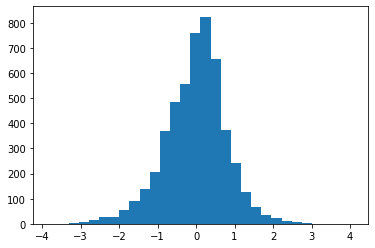

In [32]:
# visualize the distribution of the residuals
import matplotlib.pyplot as plt

plt.hist(resid, bins=30);

#### 📝 Note

We haven't done any hyper-parameter tuning, so everything we've done so far can be improved if we picked a better set of hyper-parameters.
Here are some homework ideas for you to try:
- Explore the hyper-parameters of both:
   - [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
   - [`XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
- Pick a subset of hyper-parameters and tune them using either:
   - [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
   - [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

# ✔️Summary
- `TF-IDF` is much faster than `word2vec`
- `XGBRegressor` significantly outperforms `LinearRegression` when text is vectorized using `TF-IDF`
- The performance of `LinearRegression` improves significantly when text is vectorized using `word2vec` rather than `TF-IDF`
- The performance gap between `XGBRegressor` and `LinearRegression` is small when using `word2vec`. The important point here is that a powerful text vectorization technique can lead to good results even when using simple algorithms like linear regression

### Additional resources

- [Course: Advanced NLP with spacy](https://course.spacy.io/en/)
- [Video: TF-IDF Document Similarity using Cosine Similarity](https://www.youtube.com/watch?v=hc3DCn8viWs)
- [Video: Understanding Word Embeddings 2: CBOW and Skip Gram](https://www.youtube.com/watch?v=BWaHLmG1lak)
- [Video: Word Vector Representations word2vec](https://www.youtube.com/watch?v=ERibwqs9p38)